In [12]:
# import required packages
import cv2
from matplotlib import pyplot as plt
from IPython.display import display
from PIL import Image
from platform import python_version
import io
import math
import csv
import numpy as np
from csv import DictWriter
import re
import os

import pytesseract
# Provide the path of the install location of Tesseract-OCR in your system
pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'


# Enter path of video file
video_file_path = '/Users/matthewtoberman/Dropbox/TRITONIA/CHEVRON_TSL22006/CAB-TAK-SUB-RPT-MAL-VES-2016-0054-B/MIL186_2016-09-08_10-43-00/MIL186_2016-09-08_10-43-00.mpg'

# Enter destination folder for images
full_size_image_folder =  '/Users/matthewtoberman/Dropbox/TRITONIA/TRITONIA-ROV_FOOTAGE_SCREEN_GRAB_TESTING/test_images/Frame_'
cropped_image_folder = '/Users/matthewtoberman/Dropbox/TRITONIA/TRITONIA-ROV_FOOTAGE_SCREEN_GRAB_TESTING/test_images_cropped/Frame_'
banner_info_folder = '/Users/matthewtoberman/Dropbox/TRITONIA/TRITONIA-ROV_FOOTAGE_SCREEN_GRAB_TESTING/'

# Enter video file start time and end time and frame interval for frame grab 
start_time_mins=0
start_time_secs=29
end_time_mins=0
end_time_secs=30
frame_interval=5


# Enable or disable plotting fot testing purposes 1 for on 0 for off
display_plots = 1

# Enable or disable Banner reading
banner_reading = 1

In [13]:
# Read the video from specified path this could clearly be changed to a file open box
cap = cv2.VideoCapture(video_file_path)  
# find length of entire video in frames
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# find frame of video
frame_rate=cap.get(cv2.CAP_PROP_FPS)

# find start and end frames coorresponding to start and end times
start_frame=math.floor((start_time_mins*60*frame_rate)+(start_time_secs*frame_rate))
end_frame=math.floor((end_time_mins*60*frame_rate)+(end_time_secs*frame_rate))

725


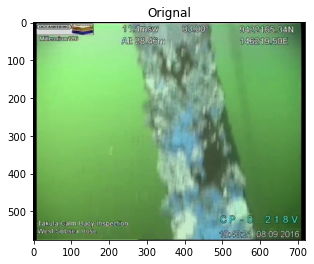

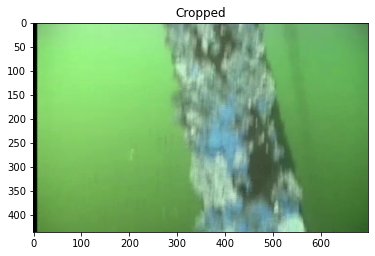

730


[h264 @ 0x7fe1e1147600] co located POCs unavailable
[h264 @ 0x7fe201054800] co located POCs unavailable


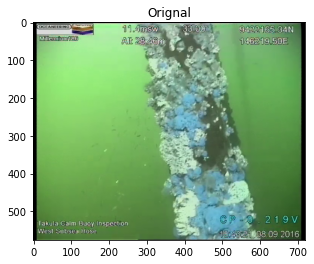

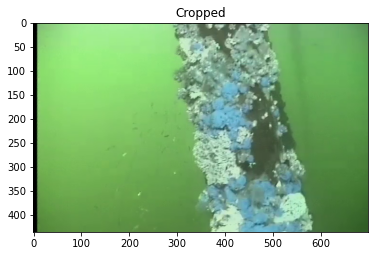

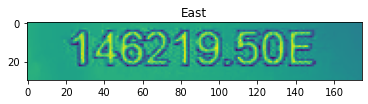

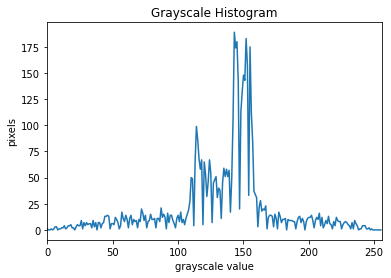

735


[h264 @ 0x7fe1e1147600] co located POCs unavailable


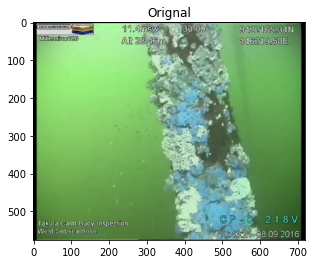

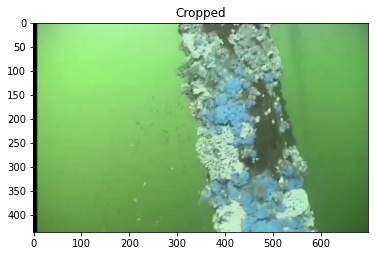

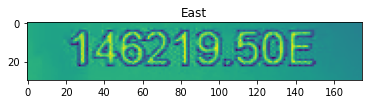

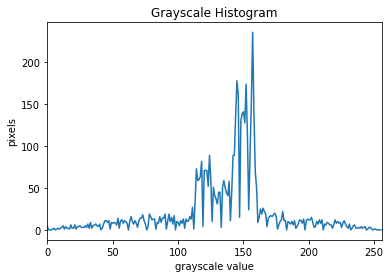

740


[h264 @ 0x7fe1e1147600] co located POCs unavailable
[h264 @ 0x7fe1e1147600] co located POCs unavailable
[h264 @ 0x7fe201054800] co located POCs unavailable


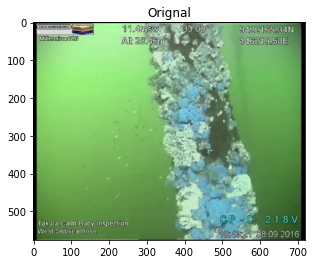

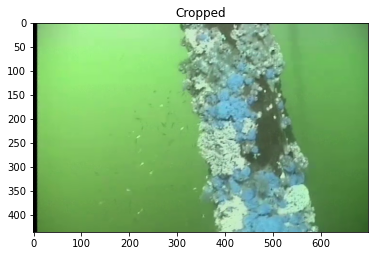

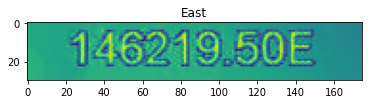

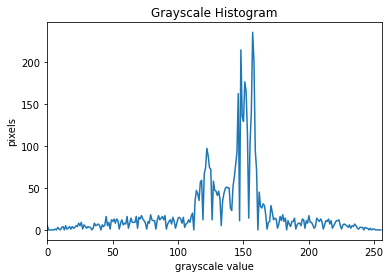

745


[h264 @ 0x7fe1e1147600] co located POCs unavailable
[h264 @ 0x7fe201054800] co located POCs unavailable


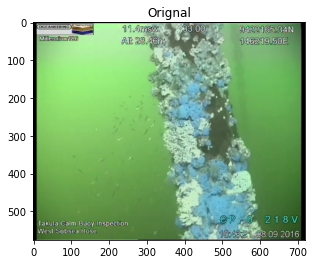

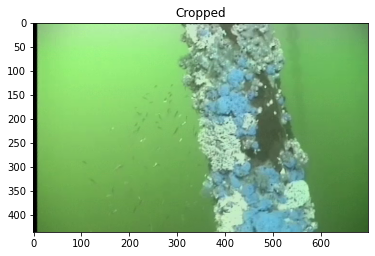

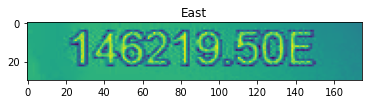

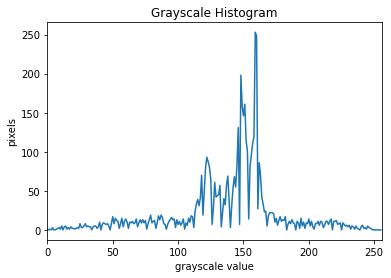

In [14]:
# Loop through specified frames 
for i in range(start_frame, end_frame, frame_interval):
    print(i)
    # choose specified frame
    cap.set(cv2.CAP_PROP_POS_FRAMES,i)
    # read specified frame
    ret, frame = cap.read()
    frame_grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # First crop banner text from image as otherwise this can be included in the blurr detection process and make the image appear in focus. These banners will need to be removed for agisoft proccesing anyhow
    #set pixel value of top of cropped image
    vert_crop_start = 65
    #set pixel value of bottom of cropped image
    vert_crop_end = frame.shape[0]-75
    # Crop frame
    crop_frame_grey = frame_grey[vert_crop_start:vert_crop_end, 1:700]
    crop_frame = frame[vert_crop_start:vert_crop_end, 1:700]


    if display_plots == 1:
        plt.imshow(frame)
        plt.title('Orignal')
        plt.show()
        plt.imshow(crop_frame)
        plt.title('Cropped')
        plt.show()

    # test for focus and reject if image is blurry 
    #taken from https://www.analyticsvidhya.com/blog/2020/09/how-to-perform-blur-detection-using-opencv-in-python/
    #apply laplace filter  and compute the variance
    fm = cv2.Laplacian(crop_frame_grey,cv2.CV_64F).var()
        ## write position values in CSV file
        # write the header
    headers = ['Frame Number', 'Blurr Value']
    blurr_data_dict = {'Frame Number' :i,'Blurr Value' : fm}
        # create CSV file for recording banner data
    with open('blurr_information.csv', mode='a')  as f_csv:
        dictwriter_object = DictWriter(f_csv, fieldnames=headers)
        dictwriter_object.writerow(blurr_data_dict)
        # Close the file object
        f_csv.close()

    # define the blurr detection threshold 
    blurr_threshold=700

    if fm < blurr_threshold:
    
        # add value of variance of laplacian filter to frame
        # cv2.putText(crop_frame, "{}: {:.2f}".format('Laplacian Filter Variance',fm), (10, 30),
        #     cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)       
        
        ## write specified frame to jpg image
        # create time stamp for frame file name
        fractional_mins, whole_mins = math.modf((i/frame_rate)/60)
        # create and save jpegs
        cv2.imwrite(cropped_image_folder + str(i) + '_' + str(round(whole_mins)) + 'mins' + '_' + str(round(fractional_mins*60)) + 'secs' + '.jpg',crop_frame)
        cv2.imwrite(full_size_image_folder + str(i)+ '_' + str(round(whole_mins)) + 'mins' + '_' + str(round(fractional_mins*60)) + 'secs' + '.jpg',frame)

        ## read banner text using OCR 
        if banner_reading ==1:
            # select area of image with required text for east position
            text_frame_E =  frame_grey[37:67, 525:700]
            if display_plots ==1:
                # show selected area for testing
                plt.imshow(text_frame_E)
                plt.title('East')
                plt.show()
                
            if display_plots ==1:
                # create the histogram
                histogram, bin_edges = np.histogram(text_frame_E, bins=256, range=(0, 256))
                    # # configure and draw the histogram figure
                plt.figure()
                plt.title("Grayscale Histogram")
                plt.xlabel("grayscale value")
                plt.ylabel("pixels")
                plt.xlim([0.0, 256])  # <- named arguments do not work here
                plt.plot(bin_edges[0:-1], histogram)  # <- or here
                plt.show()

            # create mask with indices of values that are greater than a ceratin threshold that will subsequently be removed and invert with tilde opeartor
            (T,sel_E) = cv2.threshold(text_frame_E,150,255,cv2.THRESH_BINARY)
            sel_E=~sel_E
            #  show selected area for testing
            # frame_E_test=frame
            # plt.imshow(sel_E)
            # plt.title('East')
            # plt.show()
            text_E = pytesseract.image_to_string(sel_E)
            # print(text_E)
            # compute number of integer characters
            # initialized value
            total_digits = 0
            # iterate through all characters
            for s in text_E:
            # if character is digit (return True)
                if s.isnumeric():
                    total_digits += 1
            if total_digits == 8 and  text_E[0] == '1':
                # print('captured text E = ' + text_E)
                # deal with the text string and convert to numeric position. In this case we split the text each side  of the decimal place and then select only the numeric characters, then re combine.
                text_E_int = text_E.split(".")[0]
                text_E_int = re.findall("\d+", text_E_int)[0]
                text_E_dec = text_E.split(".")[1]
                text_E_dec = re.findall("\d+", text_E_dec)[0]
                east_pos = text_E_int + '.' + text_E_dec 
                # print(str(east_pos))
            else:  
                east_pos = 9999   

            # select area of image with required text for North position
            text_frame_N =  frame_grey[3:33, 525:700]
            # # show selected area for testing
            # plt.imshow(text_frame_N)
            # plt.title('North')
            # plt.show()
            # create mask with indices of values that are greater than a ceratin threshold that will subsequently be removed and invert with tilde opeartor
            (T,sel_N) = cv2.threshold(text_frame_N,155,255,cv2.THRESH_BINARY) 
            sel_N=~sel_N
            text_N = pytesseract.image_to_string(sel_N)
            # print(text_N)
            total_digits = 0
            # iterate through all characters
            for s in text_N:
            # if character is digit (return True)
                if s.isnumeric():
                    total_digits += 1
            if total_digits == 9 and text_N[7] == "."  and text_N[8].isnumeric():
                # print('captured text N = ' + text_N)
                # deal with the text string and convert to numeric position. In this case we split the text each side  of the decimal place and then select only the numeric characters, then re combine.
                text_N_int = text_N.split(".")[0]
                text_N_int = re.findall("\d+", text_N_int)[0]
                text_N_dec = text_N.split(".")[1]
                text_N_dec = re.findall("\d+", text_N_dec)[0]
                north_pos = text_N_int + '.' + text_N_dec 
                # print(str(north_pos))
            else:
                north_pos = 9999  

            text_frame_depth_int = frame_grey[3:40,200:350]
            # create mask with indices of values that are greater than a ceratin threshold that will subsequently be removed and invert with tilde opeartor
            # show selected area for testing
            # plt.imshow(text_frame_depth_int)
            # plt.title('Depth Int')
            # plt.show()
            (T,sel_depth_int) = cv2.threshold(text_frame_depth_int,160,255,cv2.THRESH_BINARY) 
            
            sel_depth_int=~sel_depth_int
            
            
            # plt.gray()
            # plt.imshow(text_frame_depth_int)
            # plt.title('Depth')
            # plt.show()

            # plt.imshow(sel_depth_int)
            # plt.title('Depth Int')
            # plt.show()
            # read text
            text_depth_int_raw = pytesseract.image_to_string(text_frame_depth_int)
            text_depth_int = pytesseract.image_to_string(sel_depth_int)
            total_digits = 0
            text_depth_num =""
            # iterate through all characters
            for s in text_depth_int:
            # if character is digit (return True)
                if s.isnumeric() or s == ".":
                    total_digits += 1
                    text_depth_num = text_depth_num+s
            if len(text_depth_num)>0 :
                # print('captured text Depth raw  = ' + text_depth_int_raw)
                # print('captured text Depth  = ' + text_depth_int)
                # deal with the text string and convert to numeric position. 
                depth_pos = text_depth_num
            else:
                depth_pos = 9999    

            # write position values in CSV file
            headers = ['Frame Number','East Position', 'North Position','Depth']
            position_data_dict = {'Frame Number' :i,'East Position' :east_pos,'North Position' : north_pos,'Depth' : depth_pos}
            banner_file_name=banner_info_folder + 'banner_information.csv'


            # write the header
            if i == start_frame:
                if os.path.exists(banner_file_name):
                    os.remove(banner_file_name)
                with open(banner_file_name, mode='a')  as f_csv:
                    writer = csv.DictWriter(f_csv, delimiter=',', lineterminator='\n',fieldnames=headers)
                    writer.writeheader()

            # create CSV file for recording banner data
            with open(banner_file_name, mode='a')  as f_csv:
                dictwriter_object = DictWriter(f_csv, fieldnames=headers)
                dictwriter_object.writerow(position_data_dict)
                # Close the file object
                f_csv.close()
            
